## Deep Learning Prediction

### Library imports

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

### Data import

In [2]:
DATA_PATH = "../data/"

path = DATA_PATH + "Telco_data_neural.csv"

In [3]:
df = pd.read_csv(path)

### Drop unused variables

In [4]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

### Fix Column names

In [5]:
df.columns = df.columns.str.replace(' ','_')

In [6]:
df.head().T

,0,1,2,3,4
Churn_Label,1,1,1,1,1
CLTV,0.872912,0.762181,-1.032322,0.791766,-1.358595
Referred_a_Friend,No,Yes,No,Yes,Yes
Number_of_Referrals,-0.650362,-0.317162,-0.650362,-0.317162,-0.317162
Tenure_in_Months,-1.278897,-0.993672,-0.586209,-0.300984,0.187973
Offer,None,Offer E,Offer D,Offer C,Offer C
Phone_Service,No,Yes,Yes,Yes,Yes
Avg_Monthly_Long_Distance_Charges,0.0,48.85,11.33,19.76,6.33
Multiple_Lines,No,Yes,Yes,No,Yes
Internet_Service,Yes,Yes,Yes,Yes,Yes


### Split the dataframe into train, validation, and test

In [7]:
train, test = train_test_split(df, test_size=0.2, shuffle=True)
train, val = train_test_split(train, test_size=0.2, shuffle=True)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

4507 train examples
1127 validation examples
1409 test examples


### Creating an input pipeline

In [8]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, target='Churn_Label', shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop(target)
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [9]:
batch_size = 5 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

### Understanding the input pipeline

In [10]:
for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of ages:', feature_batch['Age'])
  print('A batch of targets:', label_batch )

Every feature: ['CLTV', 'Referred_a_Friend', 'Number_of_Referrals', 'Tenure_in_Months', 'Offer', 'Phone_Service', 'Avg_Monthly_Long_Distance_Charges', 'Multiple_Lines', 'Internet_Service', 'Internet_Type', 'Avg_Monthly_GB_Download', 'Online_Security', 'Online_Backup', 'Device_Protection_Plan', 'Premium_Tech_Support', 'Streaming_TV', 'Streaming_Movies', 'Streaming_Music', 'Unlimited_Data', 'Contract', 'Paperless_Billing', 'Payment_Method', 'Monthly_Charge', 'Total_Charges', 'Total_Refunds', 'Total_Extra_Data_Charges', 'Total_Long_Distance_Charges', 'Total_Revenue', 'City', 'Zip_Code', 'Latitude', 'Longitude', 'Gender', 'Age', 'Under_30', 'Senior_Citizen', 'Married', 'Dependents', 'Number_of_Dependents', 'Population']
A batch of ages: tf.Tensor([-0.62743315 -0.80653387  0.50687139  1.22327426 -1.10503507], shape=(5,), dtype=float64)
A batch of targets: tf.Tensor([0 0 0 0 0], shape=(5,), dtype=int64)


### Example batch

In [11]:
# We will use this batch to demonstrate several types of feature columns
example_batch = next(iter(train_ds))[0]

In [12]:
# A utility method to create a feature column
# and to transform a batch of data
def demo(feature_column):
  feature_layer = layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())


In [13]:
cltv = feature_column.numeric_column('CLTV')
demo(cltv)

[[ 1.047882  ]
 [-1.2132092 ]
 [-1.0289408 ]
 [ 1.0233692 ]
 [-0.31299904]]


### Creating feature columns

In [14]:
feature_columns = []

# numeric cols
for header in ['CLTV', 'Number_of_Referrals', 'Tenure_in_Months', 'Avg_Monthly_Long_Distance_Charges',  'Avg_Monthly_GB_Download',
              'Monthly_Charge', 'Total_Charges', 'Total_Refunds', 'Total_Extra_Data_Charges', 'Total_Long_Distance_Charges', 'Total_Revenue', 
              'Latitude', 'Longitude', 'Age', 'Number_of_Dependents', 'Population']:
  feature_columns.append(feature_column.numeric_column(header))

In [15]:
# # bucketized cols
# age = feature_column.numeric_column('Age')
# age_buckets = feature_column.bucketized_column(age, boundaries=[1, 2, 3, 4, 5])
# feature_columns.append(age_buckets)

In [16]:
# indicator_columns
indicator_column_names = ['Referred_a_Friend', 'Offer', 'Phone_Service', 'Multiple_Lines', 'Internet_Service', 'Internet_Type', 
                         'Online_Security', 'Online_Backup', 'Device_Protection_Plan', 'Premium_Tech_Support', 'Streaming_TV', 
                         'Streaming_Movies', 'Streaming_Music', 'Unlimited_Data', 'Contract', 'Paperless_Billing', 
                         'Payment_Method', 'Gender', 'Under_30', 'Senior_Citizen', 'Married', 'Dependents']
for col_name in indicator_column_names:
      categorical_column = feature_column.categorical_column_with_vocabulary_list(
            col_name, df[col_name].unique())
      indicator_column = feature_column.indicator_column(categorical_column)
      feature_columns.append(indicator_column)

In [17]:
# embedding columns
# embedding_column_names = ['City', 'Zip_Code']
# for col_name in embedding_column_names:
#     embedding_column = feature_column.categorical_column_with_vocabulary_list(
#         col_name, df[col_name].unique())
#     col_name_embedding = feature_column.embedding_column(col_name, dimension=8)
#     feature_columns.append(col_name_embedding)
    
# breed1 = feature_column.categorical_column_with_vocabulary_list(
#       'Breed1', dataframe.Breed1.unique())
# breed1_embedding = feature_column.embedding_column(breed1, dimension=8)
# feature_columns.append(breed1_embedding)

### Create a feature layer

In [18]:
feature_columns

[NumericColumn(key='CLTV', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Number_of_Referrals', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Tenure_in_Months', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Avg_Monthly_Long_Distance_Charges', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Avg_Monthly_GB_Download', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Monthly_Charge', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Total_Charges', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Total_Refunds', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Total_Extra_Data_Charges', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=No

In [19]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [20]:
batch_size = 64
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [21]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.1),
  layers.Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=30)

Epoch 1/30
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
64/71 [==========================>...] - ETA: 0s - loss: 0.5846 - accuracy: 0.7239WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'CLTV': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=float64>, 'Referred_a_Friend': <tf.Tensor 'ExpandDims_26:0' shape=(None, 1) dtype=string>, 'Number_of_Referrals': <tf.Tensor 'ExpandDims_17:0' shape=(None, 1) dtype=float64>, 'Tenure_in_Months': <tf.Tensor 'ExpandDims_31:0' shape=(None, 1) dtype=float64>, 'Offer': <tf.Tensor 'ExpandDims_18:0' shape=(None, 1) dtype=string>, 'Phone_Service': <tf.Tensor 'ExpandDims_23:0' shape=(None, 1) dtype=string>, 'Avg_Monthly_Long_Distance_Charges': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=float64>, 'Multiple_Lines': <tf.Tensor 'ExpandDims_15:0' shape=(None, 1) dtype=string>, 'Internet_Service': <tf.Tensor 'Ex

In [22]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

23/23 [==============================] - 0s 3ms/step - loss: 0.4044 - accuracy: 0.8332
Accuracy 0.833215057849884


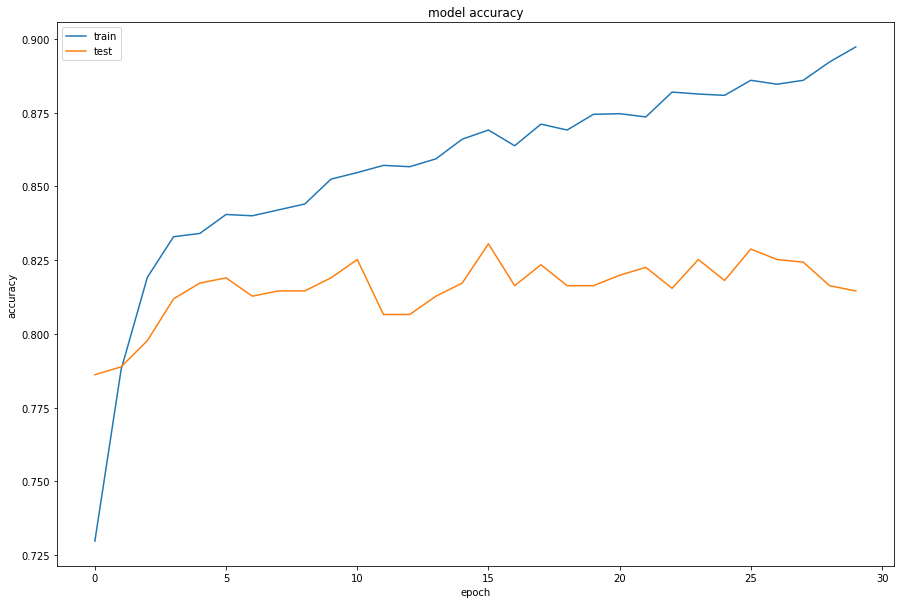

In [23]:
plt.figure(figsize=(15,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Old

In [24]:
target = df.pop('Churn Label')

dataset = tf.data.Dataset.from_tensor_slices((df.values, target.values))

KeyError: 'Churn Label'

In [ ]:
train_dataset = dataset.shuffle(len(df)).batch(1)

In [ ]:
def get_compiled_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

In [ ]:
model = get_compiled_model()
model.fit(train_dataset, epochs=15)

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(512, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])